In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
from IPython.display import clear_output
from multiprocessing import Pool
from time import time
warnings.filterwarnings('ignore')

In [2]:
beijing_aq_plus_met = pd.read_csv('tmp_beijing_aq_plus_met_preprocessed.csv.gz')
beijing_aq_plus_met.head(2)

,time,station_id,longitude,latitude,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction
0,2014-05-01 00:00:00,1002,116.205310,40.003950,89.0,132.9,30.5,0.8,96.5,7.6,0.0,20.0,56.0,7.92,13.0
1,2014-05-01 00:00:00,1003,116.184239,39.914409,105.0,196.4,79.9,0.8,75.7,9.1,0.0,20.0,56.0,7.92,13.0


In [3]:
beijing_aq_plus_met['time'] = pd.to_datetime(beijing_aq_plus_met['time'])
beijing_aq_plus_met2 = beijing_aq_plus_met.sort_values(by=['station_id', 'time'])
beijing_aq_plus_met2.head(2)

,time,station_id,longitude,latitude,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,132.9,30.5,0.8,96.5,7.6,0.0,20.0,56.0,7.92,13.0
30,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,136.6,31.8,0.8,88.6,7.3,0.0,18.0,64.0,7.56,13.0


### Asserting number of data entries per station

In [4]:
for station in beijing_aq_plus_met2.station_id.unique():
    tmp_df = beijing_aq_plus_met2[beijing_aq_plus_met2.station_id==station]
    assert tmp_df.shape == (8760, 15), print(tmp_df.shape)

interpr = ['linear', 'quadratic', 'cubic', 'spline']

### Functions

In [10]:
def process_continuous(tmp_df):
    splitter = KFold(n_splits=5, random_state=0, shuffle=True)
    for f_i, (train, test) in enumerate(splitter.split(tmp_df.index)):
        train_index = tmp_df.index[train]
        test_index = tmp_df.index[test]
        
        tmp_df['tmp_data'] = tmp_df[feature]
        tmp_df.loc[test_index, 'tmp_data'] = None
        for algo in interpr:
            filled_vals = tmp_df['tmp_data'].interpolate(method=algo, 
                                                         order=3, 
                                                         limit_direction='both').ffill().bfill()
            tmp_df[algo].loc[test_index] = filled_vals.loc[test_index]
    return tmp_df

def run_k_folds():
    data_df = beijing_aq_plus_met2[['time', 'station_id', feature]]
    for algo in interpr:
        data_df[algo] = None
    
    tmp_df_list = []
    for station in data_df.station_id.unique():
        tmp_df_list.append(data_df[data_df.station_id == station])

    workers = Pool()
    out_list = workers.map(process_continuous, tmp_df_list)
    workers.close()

    final_df = pd.concat(out_list)
    check_df = final_df.dropna(subset=[feature])
    ###
#     print(check_df.head(2))
    check_df = check_df.set_index('time').loc['2015-03-01':'2015-03-31']
#     display(check_df)
    ###
    print('###\nRMSE\n###')
    for algo in interpr:
        print(round(mean_squared_error(check_df[feature], check_df[algo], squared=False), 2), end=' & ')
    print("###")
    return final_df

### Process Continuous variables

In [11]:
init = time()
feature = 'PM25_Concentration'

out_df = run_k_folds()
print('time taken:', time()-init, 'seconds')
out_df

###
RMSE
###
15.04 & 15.63 & 15.95 & 15.9 & ###
time taken: 32.047685861587524 seconds


,time,station_id,PM25_Concentration,linear,quadratic,cubic,spline,tmp_data
0,2014-05-01 00:00:00,1002,89.0,85.0,85.0,85.0,85.400764,NaN
30,2014-05-01 01:00:00,1002,85.0,88.5,83.650948,80.22565,84.520415,85.0
60,2014-05-01 02:00:00,1002,88.0,93.0,88.345862,89.102127,88.576998,88.0
90,2014-05-01 03:00:00,1002,100.0,101.0,98.140345,98.153191,97.10383,100.0
120,2014-05-01 04:00:00,1002,109.0,109.0,114.613014,116.274644,115.650312,109.0
...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,77.0,81.25,78.298068,75.146572,75.506208,77.0
262709,2015-04-30 20:00:00,1036,94.0,83.5,79.56409,72.993144,73.666419,94.0
262739,2015-04-30 21:00:00,1036,NaN,91.0,99.598942,108.946056,104.764411,NaN
262769,2015-04-30 22:00:00,1036,88.0,94.0,94.0,94.0,215.100355,88.0


In [13]:
init = time()
feature = 'temperature'
    
out_df = run_k_folds()
print('time taken:', time()-init, 'seconds')
out_df

###
RMSE
###
1.38 & 1.58 & 1.62 & 1.65 & ###
time taken: 3.034209728240967 seconds


,time,station_id,temperature,linear,quadratic,cubic,spline,tmp_data
0,2014-05-01 00:00:00,1002,20.0,18.0,18.0,18.0,23.291469,NaN
30,2014-05-01 01:00:00,1002,18.0,19.0,19.075745,19.495432,18.685129,18.0
60,2014-05-01 02:00:00,1002,18.0,17.666667,17.223334,17.418725,16.286484,18.0
90,2014-05-01 03:00:00,1002,17.0,17.333333,17.410001,17.378087,15.382987,17.0
120,2014-05-01 04:00:00,1002,17.0,16.666667,16.113088,16.018046,15.134037,17.0
...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,25.2,26.125,26.271616,26.447724,25.479128,25.2
262709,2015-04-30 20:00:00,1036,25.0,25.55,26.825671,26.677724,23.941196,25.0
262739,2015-04-30 21:00:00,1036,NaN,24.7,25.459212,25.405055,22.532698,NaN
262769,2015-04-30 22:00:00,1036,24.4,21.533333,22.438555,23.670347,21.149461,24.4


In [14]:
init = time()
feature = 'humidity'
    
out_df = run_k_folds()
print('time taken:', time()-init, 'seconds')
out_df

###
RMSE
###
7.11 & 9.15 & 9.44 & 9.39 & ###
time taken: 20.73857879638672 seconds


,time,station_id,humidity,linear,quadratic,cubic,spline,tmp_data
0,2014-05-01 00:00:00,1002,56.0,64.0,64.0,64.0,56.954709,NaN
30,2014-05-01 01:00:00,1002,64.0,63.0,63.930563,63.600047,63.722199,64.0
60,2014-05-01 02:00:00,1002,70.0,67.666667,69.883432,70.060941,68.893182,70.0
90,2014-05-01 03:00:00,1002,74.0,71.333333,73.616898,73.841411,72.871011,74.0
120,2014-05-01 04:00:00,1002,75.0,75.333333,76.711483,76.710537,76.808141,75.0
...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,48.0,43.25,39.943629,38.781402,38.328283,48.0
262709,2015-04-30 20:00:00,1036,47.0,44.5,34.880253,35.281402,35.020101,47.0
262739,2015-04-30 21:00:00,1036,NaN,47.0,42.504249,42.779354,43.558459,NaN
262769,2015-04-30 22:00:00,1036,47.0,63.666667,58.360097,52.920318,57.085251,47.0


In [15]:
init = time()
feature = 'wind_speed'
    
out_df = run_k_folds()
print('time taken:', time()-init, 'seconds')
out_df

###
RMSE
###
3.72 & 4.66 & 4.79 & 4.6 & ###
time taken: 12.574647426605225 seconds


,time,station_id,wind_speed,linear,quadratic,cubic,spline,tmp_data
0,2014-05-01 00:00:00,1002,7.92,7.56,7.56,7.56,11.193251,NaN
30,2014-05-01 01:00:00,1002,7.56,6.84,6.18941,5.371294,7.58693,7.56
60,2014-05-01 02:00:00,1002,5.76,6.6,6.81091,6.792918,4.738994,5.76
90,2014-05-01 03:00:00,1002,6.12,5.64,5.732124,5.779376,4.078732,6.12
120,2014-05-01 04:00:00,1002,4.68,5.76,5.697546,5.521833,5.588553,4.68
...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,2.60,2.925,2.528979,2.704657,2.592873,2.60
262709,2015-04-30 20:00:00,1036,3.50,2.85,2.517696,2.634657,1.87204,3.50
262739,2015-04-30 21:00:00,1036,NaN,3.1,3.335537,3.413799,2.186336,NaN
262769,2015-04-30 22:00:00,1036,2.70,2.9,3.623703,4.479443,2.456563,2.70


## Imputing data with best methods

In [10]:
station_wise_df = []
best_methods = {'PM25_Concentration': 'linear', 
                'temperature': 'linear',
                'humidity': 'linear', 
                'wind_speed': 'linear',
                'weather': 'nearest',
                'wind_direction': 'nearest'}
for station in beijing_aq_plus_met2.station_id.unique():
    tmp_df = beijing_aq_plus_met2[beijing_aq_plus_met2.station_id == station]
    tmp_df['filled'] = True
    for var, method in best_methods.items():
        if var == 'PM25_Concentration':
            tmp_df.loc[tmp_df.dropna(subset=[var]).index, 'filled'] = False
        tmp_df[var] = tmp_df[var].interpolate(method).ffill().bfill()
    station_wise_df.append(tmp_df)
    
filled_df = pd.concat(station_wise_df)
filled_df

,time,station_id,longitude,latitude,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.003950,89.0,132.9,30.5,0.8,96.5,7.6,0.0,20.0,56.0,7.92,13.0,False
30,2014-05-01 01:00:00,1002,116.20531,40.003950,85.0,136.6,31.8,0.8,88.6,7.3,0.0,18.0,64.0,7.56,13.0,False
60,2014-05-01 02:00:00,1002,116.20531,40.003950,88.0,145.1,33.4,0.8,77.9,6.6,0.0,18.0,70.0,5.76,13.0,False
90,2014-05-01 03:00:00,1002,116.20531,40.003950,100.0,159.0,37.3,0.8,69.9,6.9,0.0,17.0,74.0,6.12,13.0,False
120,2014-05-01 04:00:00,1002,116.20531,40.003950,109.0,161.7,33.8,0.8,65.5,6.5,0.0,17.0,75.0,4.68,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,116.00000,39.579999,77.0,104.6,15.5,0.5,180.7,18.3,5.0,25.2,48.0,2.60,23.0,False
262709,2015-04-30 20:00:00,1036,116.00000,39.579999,94.0,141.2,26.1,0.6,146.1,16.9,5.0,25.0,47.0,3.50,23.0,False
262739,2015-04-30 21:00:00,1036,116.00000,39.579999,91.0,NaN,NaN,NaN,NaN,NaN,5.0,24.7,47.0,3.10,23.0,True
262769,2015-04-30 22:00:00,1036,116.00000,39.579999,88.0,NaN,23.0,0.7,120.6,15.8,5.0,24.4,47.0,2.70,23.0,False


In [11]:
for var in best_methods.keys():
    assert filled_df[var].shape == filled_df[var].dropna().shape

In [12]:
final_df = filled_df.drop(columns=['PM10_Concentration', 'NO2_Concentration', 'CO_Concentration', 'O3_Concentration', 'SO2_Concentration'])
# final_df = filled_df
final_df

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.003950,89.0,0.0,20.0,56.0,7.92,13.0,False
30,2014-05-01 01:00:00,1002,116.20531,40.003950,85.0,0.0,18.0,64.0,7.56,13.0,False
60,2014-05-01 02:00:00,1002,116.20531,40.003950,88.0,0.0,18.0,70.0,5.76,13.0,False
90,2014-05-01 03:00:00,1002,116.20531,40.003950,100.0,0.0,17.0,74.0,6.12,13.0,False
120,2014-05-01 04:00:00,1002,116.20531,40.003950,109.0,0.0,17.0,75.0,4.68,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...
262679,2015-04-30 19:00:00,1036,116.00000,39.579999,77.0,5.0,25.2,48.0,2.60,23.0,False
262709,2015-04-30 20:00:00,1036,116.00000,39.579999,94.0,5.0,25.0,47.0,3.50,23.0,False
262739,2015-04-30 21:00:00,1036,116.00000,39.579999,91.0,5.0,24.7,47.0,3.10,23.0,True
262769,2015-04-30 22:00:00,1036,116.00000,39.579999,88.0,5.0,24.4,47.0,2.70,23.0,False


### Final corrections (anomaly removal)

In [13]:
mask = (final_df.station_id==1008) & (final_df.PM25_Concentration>400)
final_df.loc[mask, 'PM25_Concentration'] = None

mask = (final_df.station_id==1016) & (final_df.PM25_Concentration>125) & (final_df.time>='2015-03-09') & (final_df.time <= '2015-03-10')
final_df.loc[mask, 'PM25_Concentration'] = None

final_df['PM25_Concentration'] = final_df['PM25_Concentration'].interpolate(method='linear')

In [14]:
final_df.to_csv('../data/processed/final_data_mar.csv.gz', index=None)

### Visualize filled data

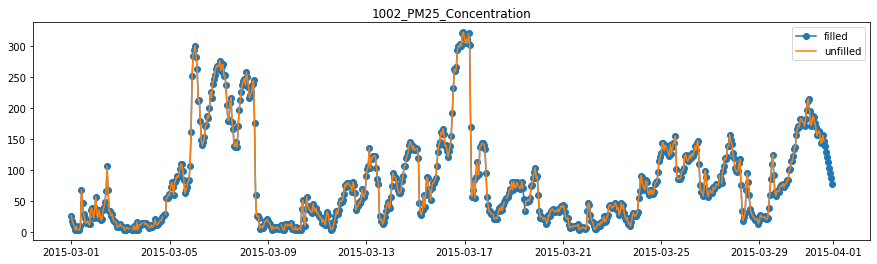

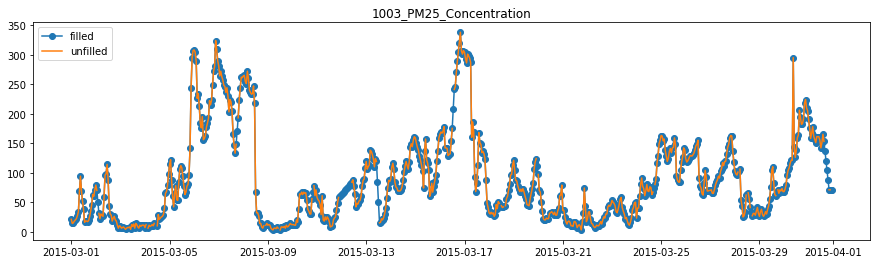

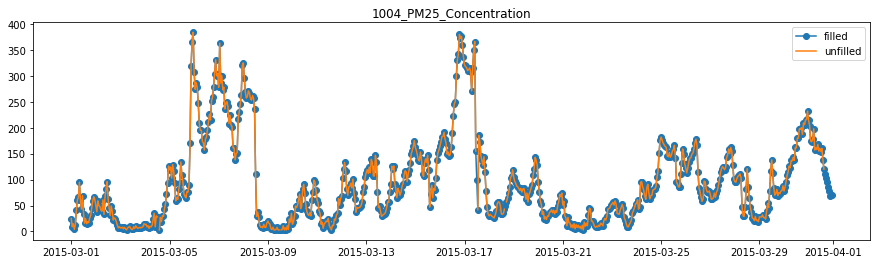

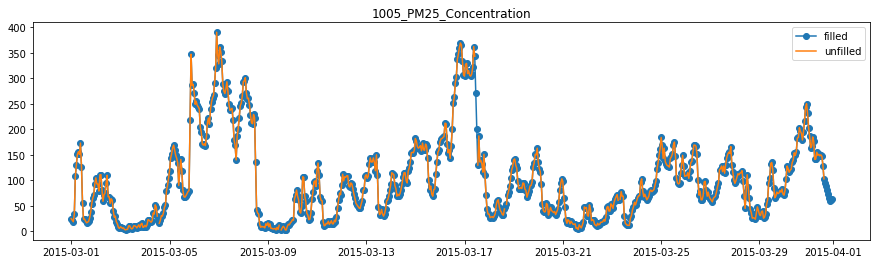

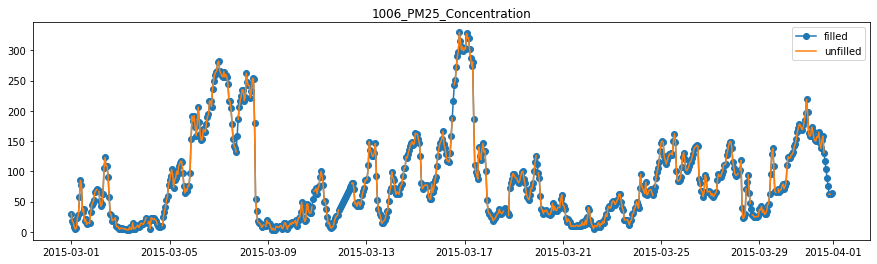

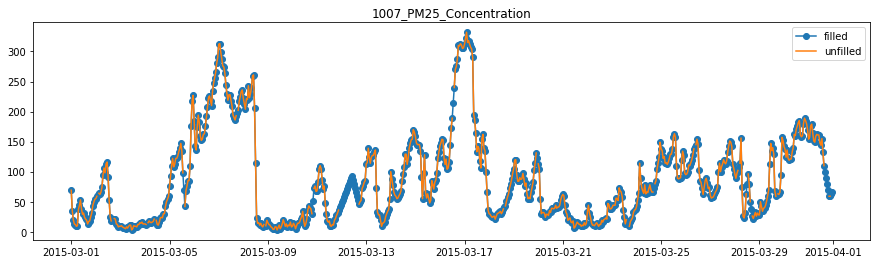

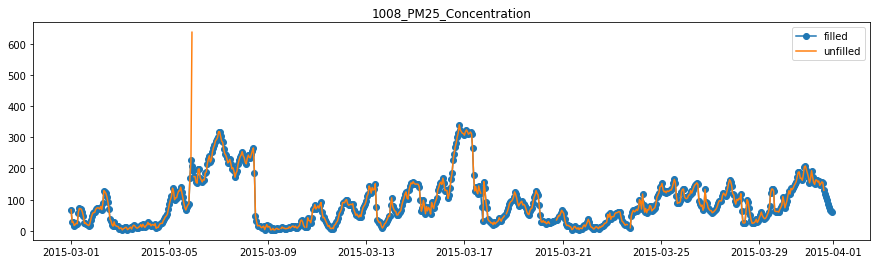

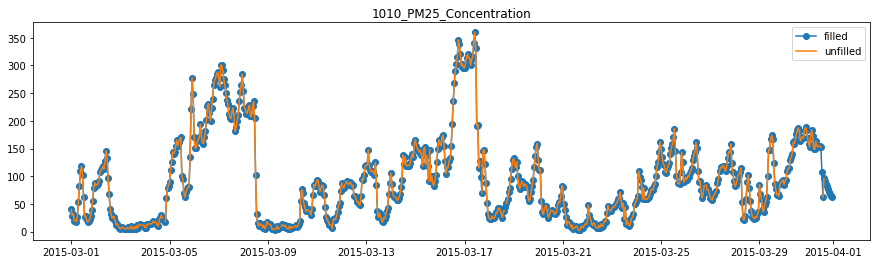

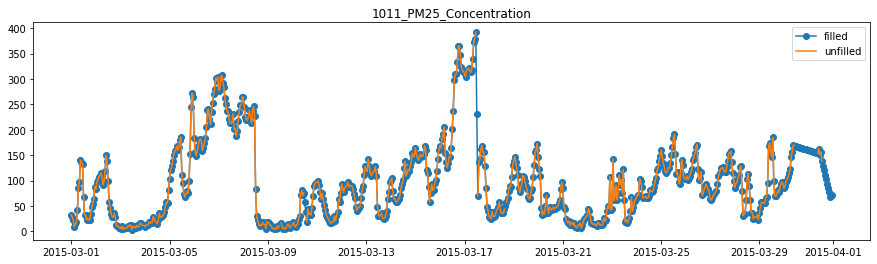

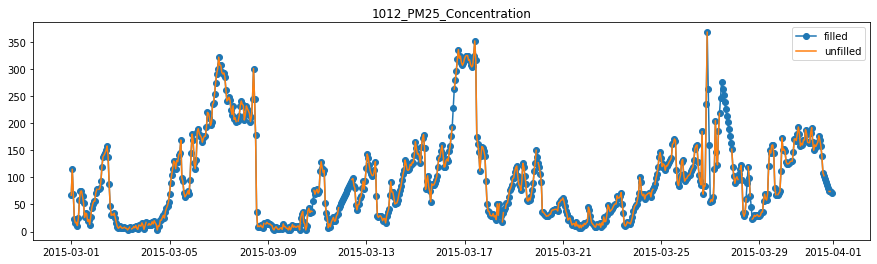

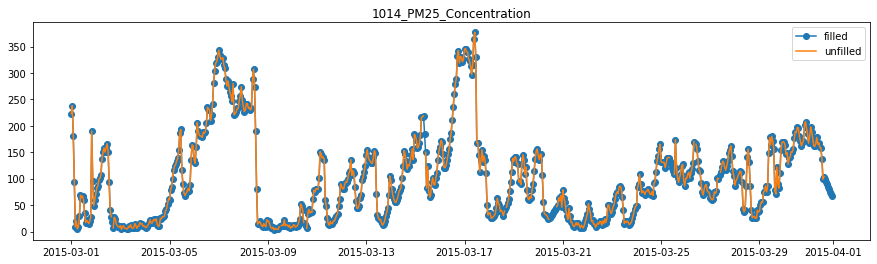

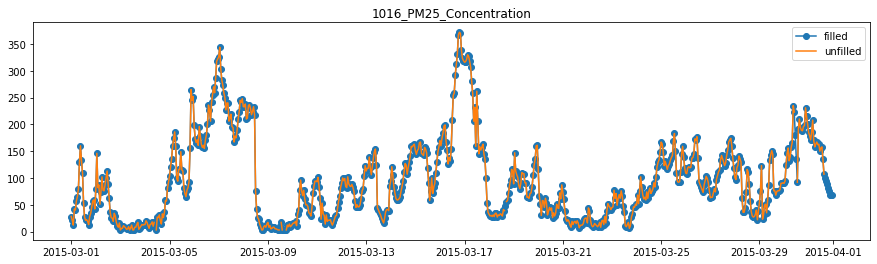

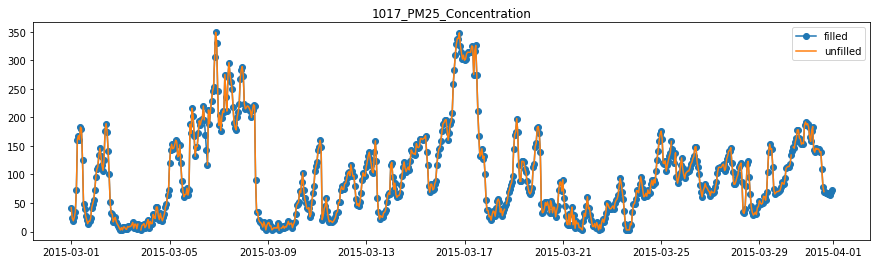

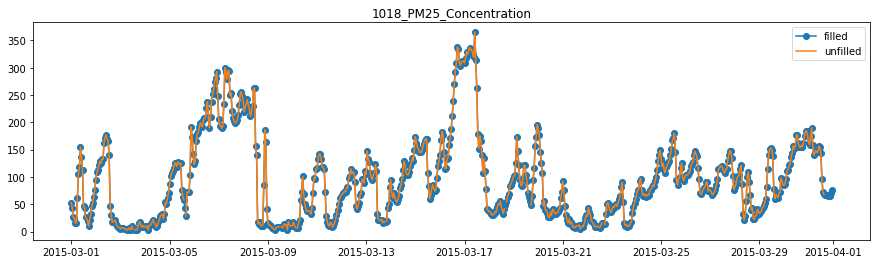

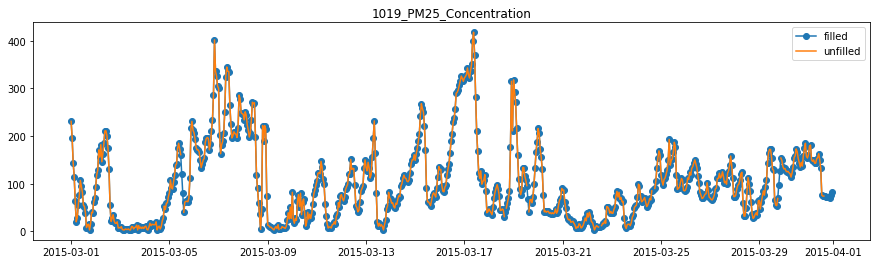

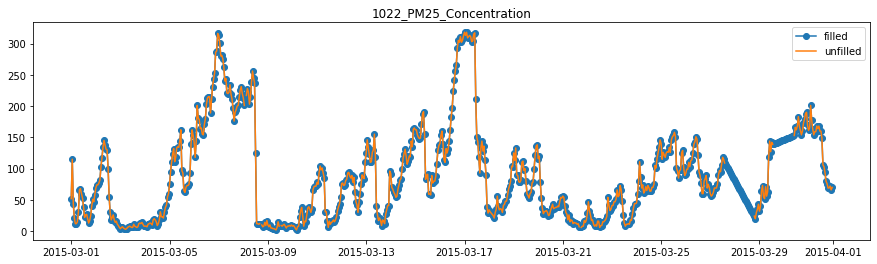

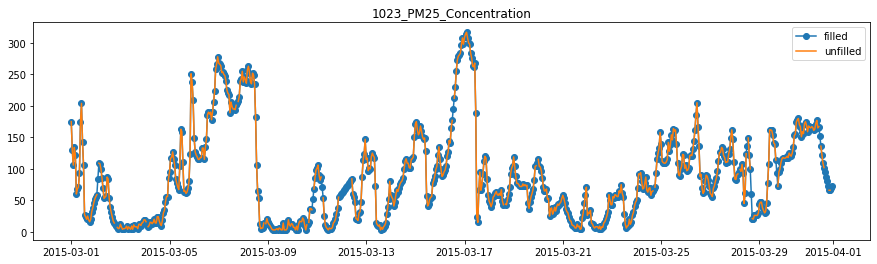

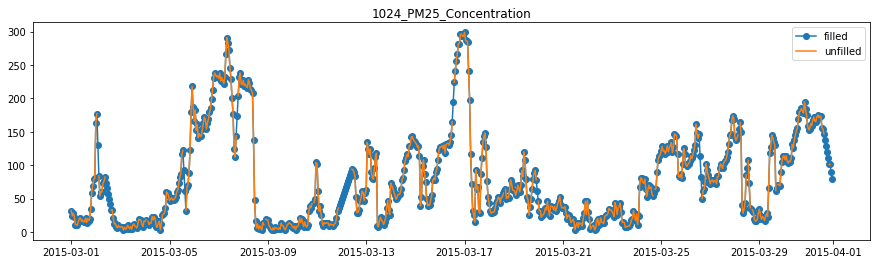

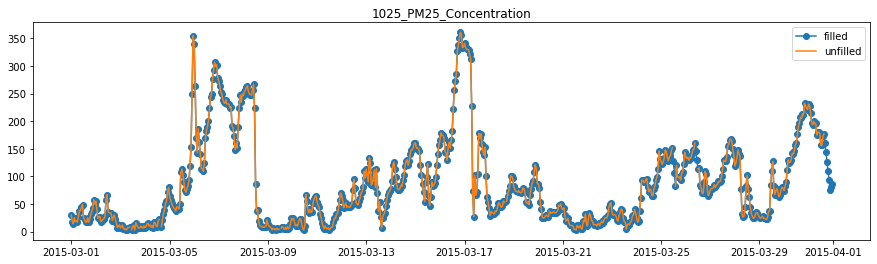

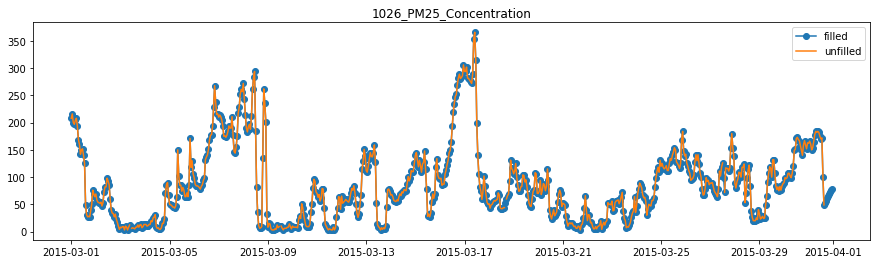

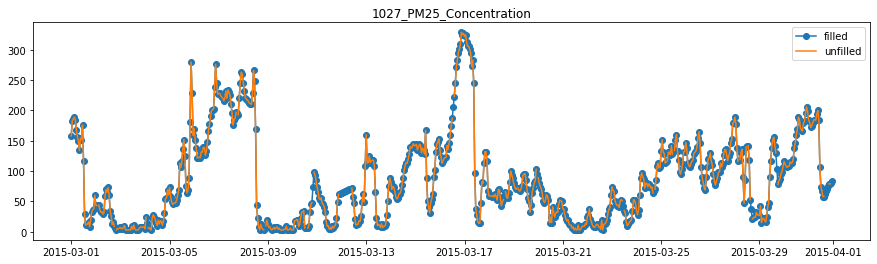

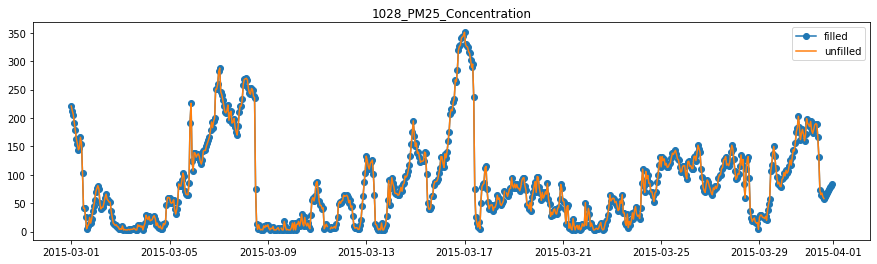

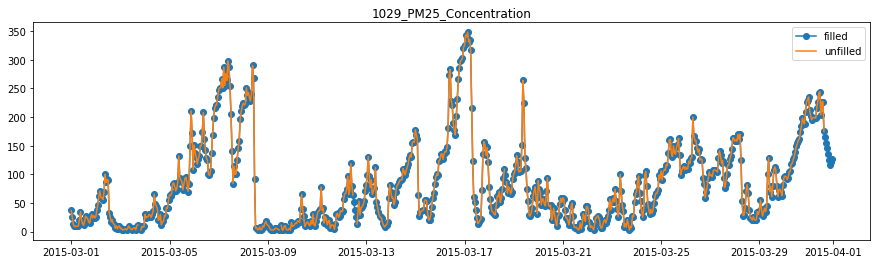

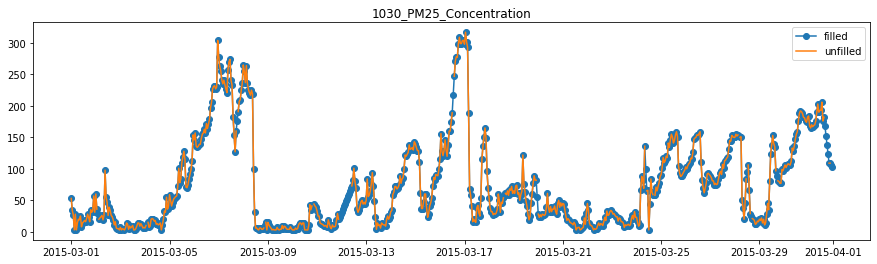

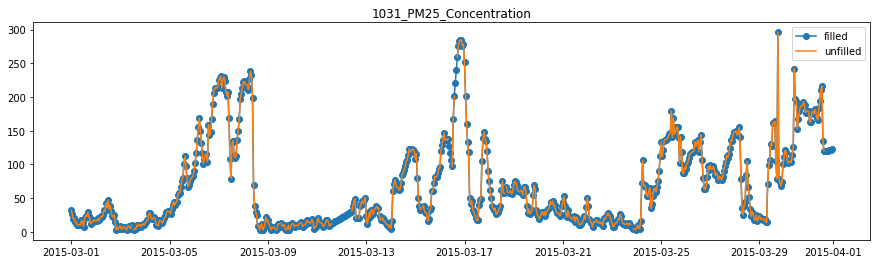

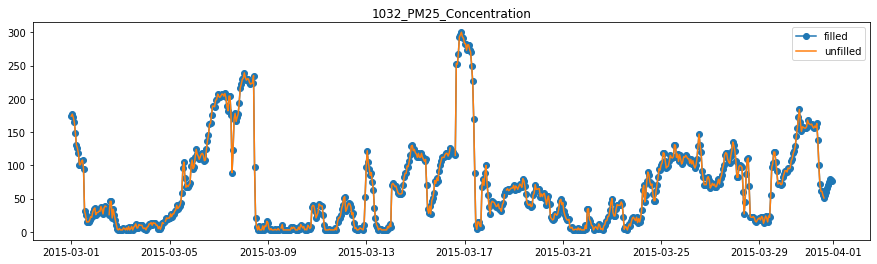

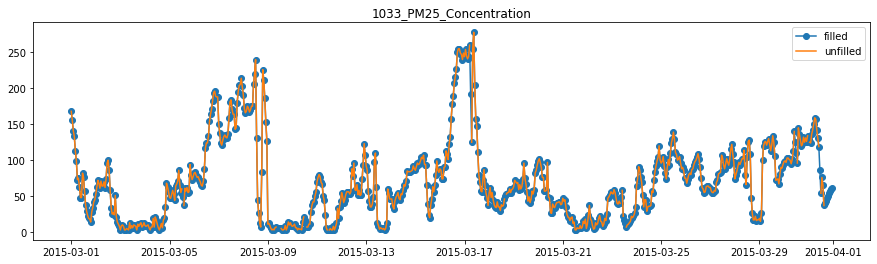

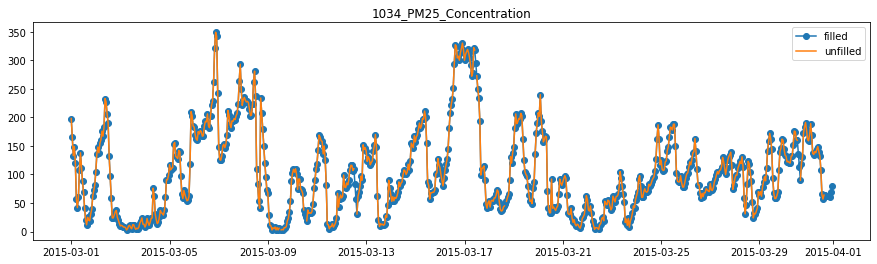

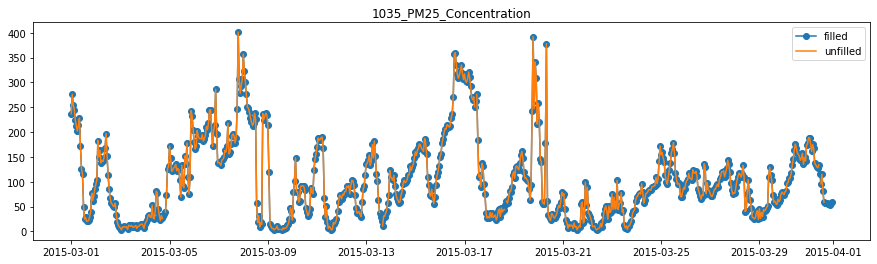

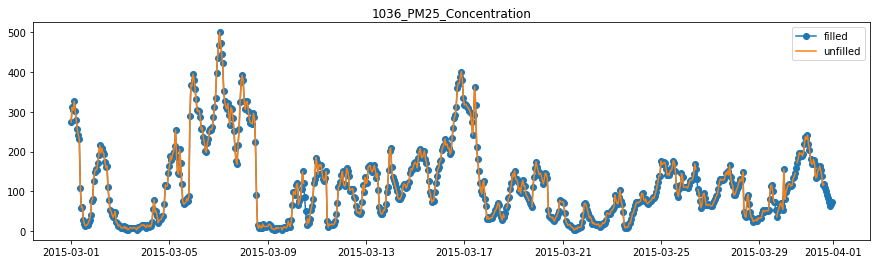

In [15]:
final_df = pd.read_csv('../data/processed/final_data_mar.csv.gz')
final_df['time'] = pd.to_datetime(final_df['time'])
feature = 'PM25_Concentration'

for station in final_df.station_id.unique():
    plt.figure(figsize=(15,4))
    unfilled = beijing_aq_plus_met2[beijing_aq_plus_met2.station_id == station]
    unfilled = unfilled.set_index('time')['2015-03']
    filled = final_df[final_df.station_id == station]
    filled = filled.set_index('time')['2015-03']
    plt.plot(filled.index, filled[feature], 'o-', label='filled')
    plt.plot(unfilled.index, unfilled[feature], label='unfilled')
    plt.title(str(station) + '_' +feature)
    plt.legend()